<a href="https://colab.research.google.com/github/arfianaja/training/blob/main/82%25yoga-vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn;
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import cv2
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
!unzip '/content/drive/MyDrive/data/dataawan.zip'

Archive:  /content/drive/MyDrive/data/dataawan.zip
  inflating: dataset_awan/nimbostratus/nimbostratus (1).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (32).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (13).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (1)_11zon.jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (30).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (36).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (78).JPG  
  inflating: dataset_awan/nimbostratus/nimbostratus (67).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (89).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (95).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (109).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (2)_11zon.jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (17).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (91).jpg  
  inflating: dataset_awan/nimbostratus/nimbostratus (74).

In [4]:
class_names = ['cumulonimbus', 'cumulus', 'stratocumulus','nimbostratus', 'stratus']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [6]:
def load_data():
    datasets = [r'/content/dataset_awan',
                r'/content/dataset_awan']
    output = []

    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/dataset_awan


100%|██████████| 366/366 [00:00<00:00, 399.14it/s]


Loading /content/dataset_awan


100%|██████████| 366/366 [00:00<00:00, 370.40it/s]


In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=5)

In [9]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]

print("Training Examples = {}".format(n_train))
print("Testing Examples = {}".format(n_test))
print("Image Size = {}".format(IMAGE_SIZE))

Training Examples = 2111
Testing Examples = 2111
Image Size = (224, 224)


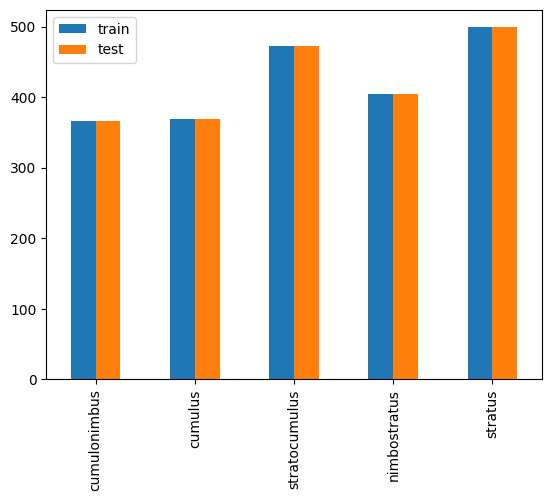

In [10]:
import pandas as pd
_,train_counts = np.unique(train_labels, return_counts=True)
_,test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train':train_counts, 'test':test_counts}, index=class_names).plot.bar()
plt.show()

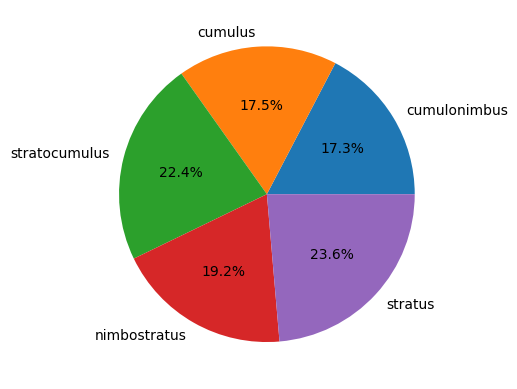

In [11]:
plt.pie(train_counts, labels=class_names, autopct='%1.1f%%')
plt.show()

In [12]:
#scaling the data,
train_images /= 255.0
test_images /= 255.0

In [13]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])

    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.title("Image #{}".format(index+1)+" "+class_names[labels[index]])
    plt.show()

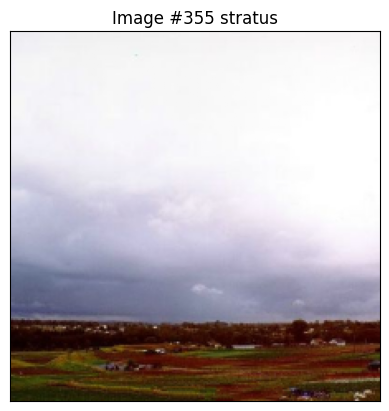

In [14]:
display_random_image(class_names, train_images, train_labels)

In [15]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples",fontsize=12)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(class_names[labels[i]])
    plt.show()

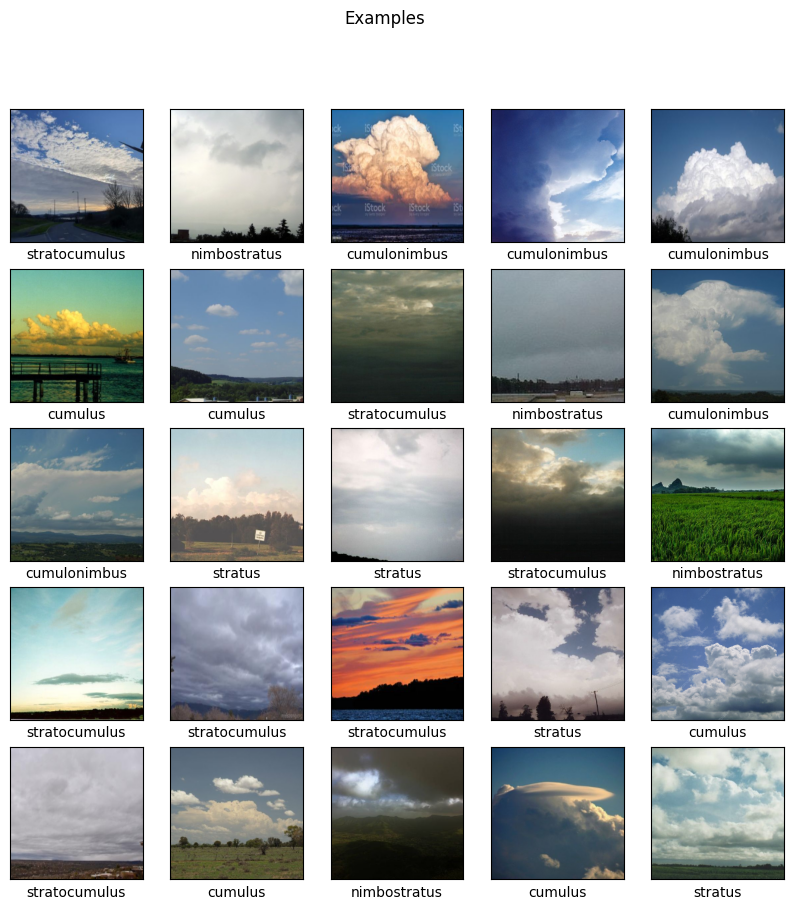

In [16]:
display_examples(class_names, train_images, train_labels)

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

model = VGG16(weights='imagenet', include_top=False)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [18]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

66/66 [==============================] - 8s 115ms/step


In [19]:
# Load the VGG16 model without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers, unfreeze later ones (adjust as needed)
for layer in vgg16_base.layers[:-5]:  # Example: unfreeze the last 5 layers
    layer.trainable = False

# Define the new model on top of the VGG16 base
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(50, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile and train the model using the original images (224, 224, 3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=32, epochs=50, validation_split=0.3)

Epoch 1/50
47/47 [==============================] - 25s 432ms/step - loss: 1.6246 - accuracy: 0.2735 - val_loss: 1.4609 - val_accuracy: 0.3028
Epoch 2/50
47/47 [==============================] - 10s 203ms/step - loss: 1.4269 - accuracy: 0.3392 - val_loss: 1.3876 - val_accuracy: 0.3785
Epoch 3/50
47/47 [==============================] - 12s 257ms/step - loss: 1.3559 - accuracy: 0.3805 - val_loss: 1.4311 - val_accuracy: 0.3549
Epoch 4/50
47/47 [==============================] - 10s 208ms/step - loss: 1.3055 - accuracy: 0.4049 - val_loss: 1.3651 - val_accuracy: 0.3754
Epoch 5/50
47/47 [==============================] - 12s 264ms/step - loss: 1.2413 - accuracy: 0.4374 - val_loss: 1.3106 - val_accuracy: 0.3722
Epoch 6/50
47/47 [==============================] - 13s 269ms/step - loss: 1.1708 - accuracy: 0.4990 - val_loss: 1.3665 - val_accuracy: 0.4211
Epoch 7/50
47/47 [==============================] - 13s 268ms/step - loss: 1.1497 - accuracy: 0.4739 - val_loss: 1.3462 - val_accuracy: 0.4306

In [20]:
def plot_accuracy_history(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

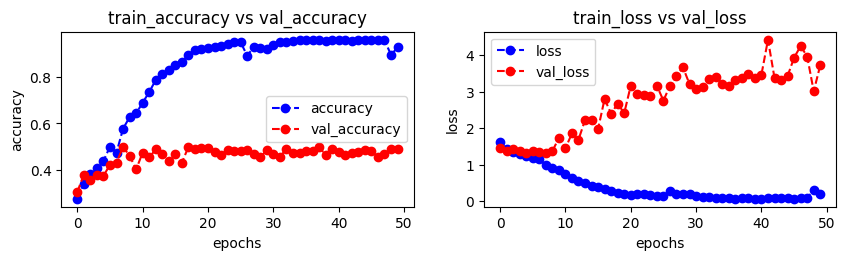

In [21]:
plot_accuracy_history(history)

66/66 [==============================] - 9s 136ms/step


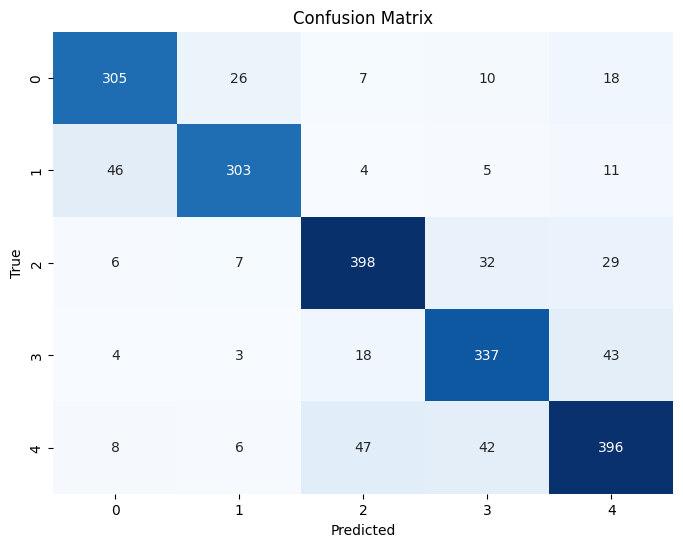

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi label untuk data uji
test_predictions = model.predict(test_images)  # Use original test images
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Buat confusion matrix
cm = confusion_matrix(test_labels, test_predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import classification_report
test_prediction = model.predict(test_images)
test_prediction_label = np.argmax(test_prediction, axis=1)
print(classification_report(test_labels, test_prediction_label))

66/66 [==============================] - 9s 137ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       366
           1       0.88      0.82      0.85       369
           2       0.84      0.84      0.84       472
           3       0.79      0.83      0.81       405
           4       0.80      0.79      0.80       499

    accuracy                           0.82      2111
   macro avg       0.83      0.82      0.83      2111
weighted avg       0.82      0.82      0.82      2111



In [24]:
print(model.input_shape)

(None, 224, 224, 3)


In [25]:
#save model
model.save('model-vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
